# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = UnityEnvironment(file_name="../p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:\n', type(state))
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like:
 <class 'numpy.ndarray'>
States have length: 37


Please refer to the instructions in `Deep_Q_Network.ipynb` if you would like to write your own DQN agent.  Otherwise, run the code cell below to load the solution files.

In [5]:
# from dqn_agent import Agent
#
# agent = Agent(state_size=state_size, action_size=action_size, seed=0)
#
# # watch an untrained agent
# env_info = env.reset(train_mode=False)[brain_name]
# state = env_info.vector_observations[0]
# total_rewards = 0
#
# for j in range(200):
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     total_rewards += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
#
# print(total_rewards)

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

In [6]:
import time

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        episode_start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]             # TODO: maybe start at random spot?
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} ({:.2f} seconds; {} {})'.format(i_episode, np.mean(scores_window), time.time()-episode_start, t, done), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}                           '.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


In [7]:
from dqn_agent import Agent

# (fc1, fc2, fc3, batch_size, learn_every, update_every, tau, lr, b, double)
learning_configs = [
    (state_size * 2, state_size * 2, 0, 64, 4, 4, 0.001, 5e-4, 0, True),
]

'''
(74, 74, 0, 64, 4, 4, 0.001, 0.0005, 0, True) 2000 1240 27.0 [9.0, 17.0, 17.0]
(74, 74, 0, 64, 8, 2, 0.001, 0.0005, 0, True) 2000 1959 28.0 [14.0, 13.0, 21.0]
(74, 74, 0, 64, 8, 4, 0.001, 0.0005, 0, True) 2000 1886 26.0 [14.0, 17.0, 15.0]
(74, 74, 0, 64, 4, 2, 0.001, 0.0005, 0, True) 2000 1423 26.0 [19.0, 12.0, 14.0]
(74, 74, 0, 128, 8, 4, 0.001, 0.0005, 0, True) 2000 1654 27.0 [0.0, 15.0, 19.0]
'''

results = []
for lc in learning_configs:
    print(f'{lc}')
    results.append(
        {
            'config': lc,
            'scores': dqn(Agent(
                state_size=state_size,
                action_size=action_size,
                seed=42,
                learning_config=lc
            ), n_episodes=2000)
        }
    )

for d in results:
    print(d['config'], len(d['scores']), np.argmax(d['scores']), np.max(d['scores']), d['scores'][-3:])

(74, 74, 0, 64, 4, 4, 0.001, 0.0005, 0, True)


/Users/jimparker/Sync/jpl/projects/Value-based-methods/banana-solution/dqn_agent.py:72: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Episode 100	Average Score: 0.06                           
Episode 200	Average Score: 1.10                           
Episode 300	Average Score: 3.09                           
Episode 400	Average Score: 6.33                           
Episode 500	Average Score: 9.17                           
Episode 600	Average Score: 11.24                           
Episode 700	Average Score: 12.30                           
Episode 782	Average Score: 13.01 (0.52 seconds; 299 True)
Environment solved in 682 episodes!	Average Score: 13.01
(74, 74, 0, 64, 4, 4, 0.001, 0.0005, 0, True) 782 603 22.0 [15.0, 16.0, 16.0]


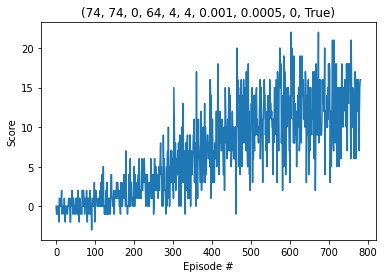

In [8]:
# plot the scores
for r in results:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(r['scores'])), r['scores'])
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(f"{r['config']}")
    plt.show()